<a href="https://colab.research.google.com/github/shkwo-n/Leather-Anomaly-Detection-CV/blob/main/MVTEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn
import torchvision
from torchvision import models

import torchvision.utils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from torchsummary import summary

import torch.nn.functional as F
import torch.optim as optim
import time
import copy

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Custom Dataset 만들기

#### From Train Folder

In [57]:
root_dir="/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/"

train_file_list = glob.glob(root_dir + "*")

train_data = []

for class_path in train_file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g.
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.png"):
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        train_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(len(train_data))

245


In [58]:
train_data[0]

['/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png',
 'good']

(1024, 1024)

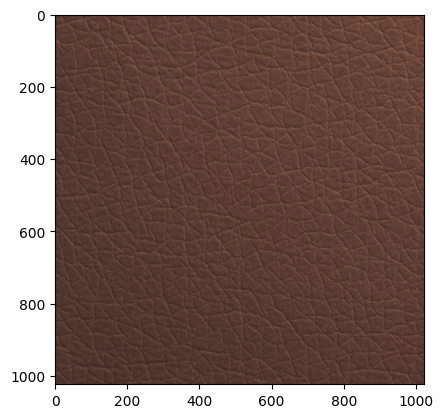

In [6]:
from PIL import Image

img = Image.open('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png')
plt.imshow(img)
img.size

In [59]:
img = cv2.imread('/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/train/good/000.png', cv2.IMREAD_COLOR)
img.shape

(1024, 1024, 3)

#### From Test Folder

In [60]:
root_dir = "/content/drive/MyDrive/SW 전문 인재 양성/SW스마트팩토리/개인플젝/mvtec/leather/test/"

# Retrieve the list of ALL folders and files inside the base folder
test_file_list = glob.glob(root_dir + "*")

test_data = []
# Create a list that would contain the paths to all the images in the dataset
for class_path in test_file_list:
    class_name = class_path.split("/")[-1] # extract the class name, e.g.
    # Retrieve each image in their folders (i.e. 0.jpg, 1.jpg, etc.)
    for img_path in glob.glob(class_path + "/*.png"):
        # Check for problematic images
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if type(img) is np.ndarray:
          if img.size == 0:
            continue
        if img is None:
            continue
        test_data.append([img_path, class_name]) # append image file path to init_data list, and its class name

print(len(test_data))

124


In [61]:
class CustomData(Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        # Dictionary containing mapping between string and number (class label)
        self.class_map = {"good":0,"color" : 1, "cut": 1,"fold":1, "glue":1, "poke":1}
        # Set image dimensions
        self.img_dim = (1024, 1024)
        # Perform any transformations
        self.transform= transform

    def __len__(self):
        return len(self.data)

    # This function is called when an element of this class is accessed via dataset[index]
    def __getitem__(self, index):
        # Get image path and class name
        img_path, class_name = self.data[index] # tuple from __init__()
        # Obtain the image from its path and resize it to the required dimension
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, self.img_dim)
        class_id = self.class_map[class_name] # get the class label, e.g. 0 (for "Dog")
        pil_img=Image.fromarray(img) # convert ndarray to PIL
        # Perform transforms if there are any
        if self.transform:
            img_tensor = self.transform(pil_img)
        # Convert class label to a tensor
        class_id = torch.tensor(class_id)

        return img_tensor, class_id

In [62]:
train_transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

test_transform=transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [63]:
trainset = CustomData(train_data, transform=train_transform)
testset = CustomData(test_data, transform=test_transform)

train_loader = DataLoader(trainset, batch_size=24,
                          shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(testset, batch_size=24,
                          shuffle=False, num_workers=2, pin_memory=True)

##### Augmentation 확인

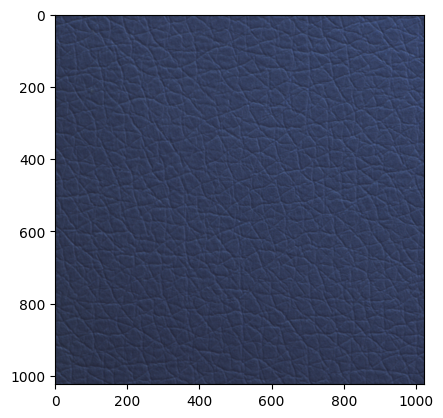

In [64]:
# extract image data
image_data = trainset[0][0]

# normalize image data from 0 to 1
if image_data.min() < 0.0:
    image_data = (image_data + 1.0) / 2.0

plt.imshow(image_data.permute(1, 2, 0))
plt.show()

### Plan
1) AutoEncoder를 통해서 이상 탐지

2) 이상으로 탐지한 이미지를 YOLO 모델을 통해 object detection을 통해 특징 추출 후 multi class classifiction 진행